<a href="https://colab.research.google.com/github/evanolsdal/TimeGAN-Finance-Project/blob/main/TimeGAN_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Overview**

This notebook walks through the steps of loading in the code and data, preprocessing the data, initializing the TimeGAN model, training the TimeGAN model, and finally visualizing the results.

## Install and Load Modules

Clone the github repository, then install and load the necessary modules.

First Connect to the repo direcotry. This only needs to be done once, so if this is first time opening notebook on own drive then uncomment the line of code below and run this cell to download git repo to files and move to it.

In [1]:
# Get git repo

!git clone https://github.com/evanolsdal/TimeGAN-Finance-Project

fatal: destination path 'TimeGAN-Finance-Project' already exists and is not an empty directory.


In [2]:
# change to repo directory

%cd TimeGAN-Finance-Project/

/content/TimeGAN-Finance-Project


If updates are made to the repo run the following lines to load the latest version.

In [3]:
# fetch changes made to remote repository
!git fetch

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), 382 bytes | 382.00 KiB/s, done.
From https://github.com/evanolsdal/TimeGAN-Finance-Project
   d551821..f166573  main       -> origin/main


In [4]:
# merge the fetched changes with the current local repository
!git merge origin/main

Updating d551821..f166573
Fast-forward
 src/visualizations.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


Next install the requirements and load the modules.

In [ ]:
!pip install -r requirements.txt

In [5]:
import numpy as np
from src.timeGAN import TimeGAN
from data_preprocessing import processing as p
from src import visualizations as v

## Data Preprocessing

Next get the data and transform it into the right shape for training.

This is done in the following order:


1.   Load raw data, one for dates and one for values
2.   Transform values to percentage change
3.   Generate sequences



In [6]:
# load data
dates = p.import_data("SP500 raw.csv", True)
data = p.import_data("SP500 raw.csv", False)

# transform to % change
data = p.transform_percent_change(data)

# generate sequences
seq_length = 24
sequences, scaler = p.generate_sequences(data, seq_length, True, 10, 'normalize')

You can print the sequences below to make sure they are in the right form.

In [ ]:
np.shape(sequences)
print(sequences)

You can also visualize some of the sequences to make sure everything looks correct.

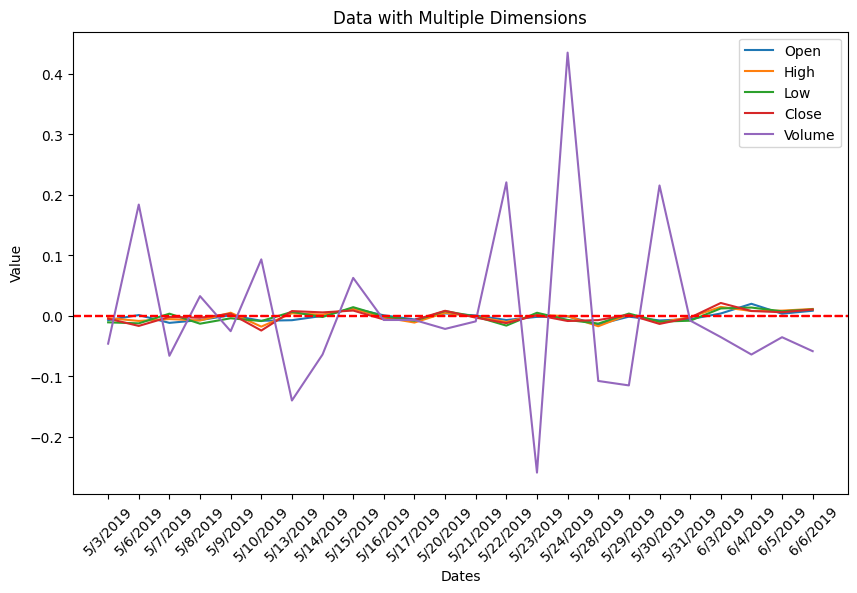

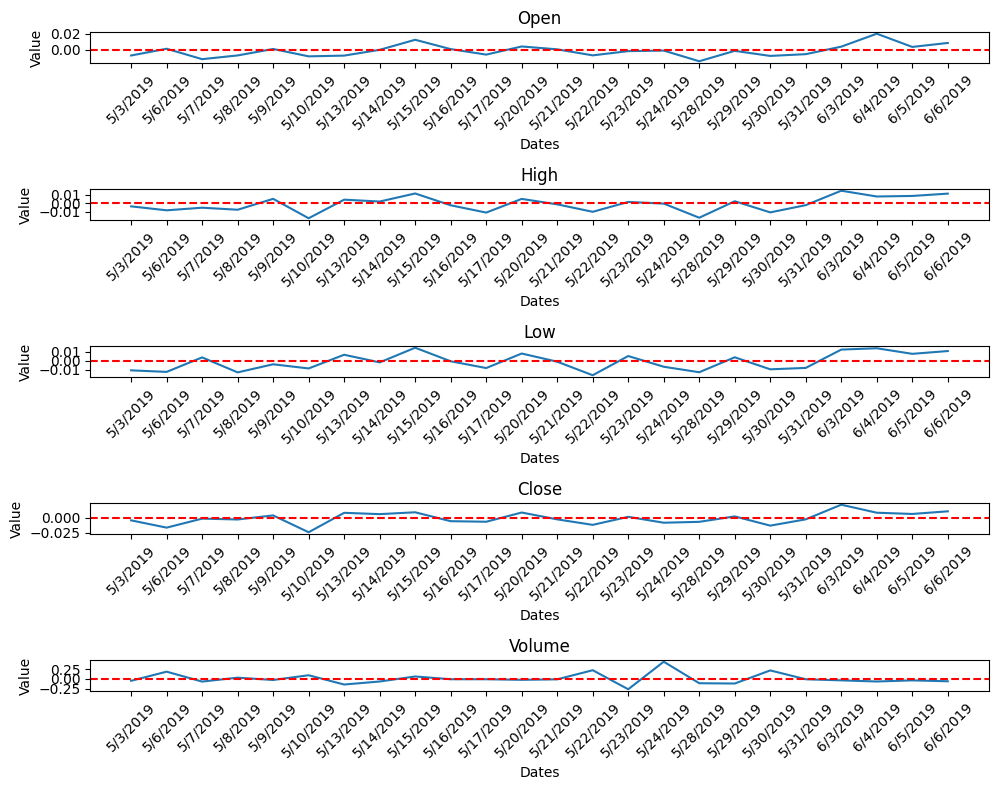

In [7]:
feature_labels = ["Open","High","Low","Close","Volume"]
v.plot_real_sequence(dates, data, feature_labels, seq_length)

## Initializing Model

Now it's time to initialize the TimeGAN model.

The model is made up of 5 distinct Netwroks:

  1. **Generator:** The main network of interest in the model. It's reponsible for mimicing the real data generating process, and is the network that synthetic sequences are drawn from later on.
  2. **Embedder:** Responsible for learning an embedded representation of the time series data. The hope is that the learned representation will capture the characteristics most significant to the real data generating process, while filtering out some of the statistical noise. This in turn provides the Generator with a cleaner data generating process to mimic.
  3. **Recovery:** Responsible for learning how to map the data from the embedded space back to the real space. This way sequences drawn from the Generator later on can be mapped back to the real space.
  4. **Supervisor:** This component facilitates the generators leanring of the proper stepwise dynamics of the real data, and is the vital component that distinguishes the TimeGAN from other recurrent GAN models.
  5. **Discriminator:** Responsible for teaching the Generator how to mimic the data, by itself learning to distinguish between the Generators synthetic output and the real time series data.

Together these components comprise the full TimeGAN model. The pricise role of each network part, and the way they interact with eachother, will be described in more detail in the training section below.


The TimeGAN has the following input parameters:

1. model_dimensions: a dict containing all of the dimension needed for the model, containing
   * seq_length: length of time steps
   * input_features: number of features given to the embedder
   * output_features: number of features to output
   * embedded_dims: number of dimensions desired for hidden layers
2.  model_parameters: a dict containing all of the parameters used to set up the model
   * n_layers: number of layers desired for each time step
   * mu: regularizes the generator supervised loss when training the generator
   * phi: regularizes the generator supervised loss when training the supervisor
   * lambda: regularizes the supervised loss when training the embedder
   * alpha_1: learning rate for the Adam optimizer in autoencoder training
   * alpha_2: learning rate for the Adam optimizer in dynamic training
   * theta: scaling factor for the tanh function
3. loss_funcitons: a dict containing all of the loss functions used for training
   * reconsruction_loss: loss for the autoencoder
   * supervised_loss: supervised loss function
   * unsupervised_loss: unsupervised loss function
4. batch_size: batch size for training

In [8]:
# First import the loss functions
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError

# Next define the input parameters
model_dimensions = {"seq_length":seq_length, "input_features":10, "output_features":5, "embedded_dims":5}
model_parameters = {"n_layers":3, "mu":.5, "phi":.25, "lambda":0.1, "alpha_1":0.005, "alpha_2":0.001, "theta":2}
loss_functions = {"reconstruction_loss":MeanSquaredError(),
                      "supervised_loss":MeanSquaredError(),
                      "unsupervised_loss":BinaryCrossentropy()}
batch_size = 100

Next use these to initialize a TimeGAN model

In [15]:
model = TimeGAN(model_dimensions, model_parameters, loss_functions, batch_size)

Make sure that the model parts are correctly constructed

In [ ]:
model.get_summary()

And finally compile so it's ready for training

In [16]:
model.compile()

# Training

The TimeGAN model training can be broken down into two separate training procedures:

1. **Autoencoder Training:** This trains the model's embedder, supervisor, and recovery simultaneously to achieve two main objectives: learning an effective two-way mapping between latent and real space, and teaching the Supervisor the stepwise dynamics of the real sequences.
2. **Dynamic Training:** This trains the model's generator and discriminator in a dynamic game while simultaneously updating the Embedder and Supervisor. Here, the Discriminator teaches the Generator to mimic the overall structure of the real sequences, while the Supervisor teaches the Generator to mimic the stepwise dynamics of the real sequences. At the same time, the Supervisor and Embedder are updated to assist the Generator's learning, while the Recovery is readapted to the new Embedder.

Each prodcedure is run separately in the sections below.

### Autoencoder Training

The Autoencoder Training consists of updates to two different loss functions:

* **Reconstruction Loss:** The Embedder and Recovery networks jointly learn the two way mapping between latent and real space by minimizing the distance between each real sequence and its corresponding recovered form.
* **Supervised Loss:** The Supervisor learns the stepwise representation of the real sequences by learning how to predict the next timestep output of the real data. This is achieved by minimizing the distance between the Supervisors current hidden state output and the Embedders next hidden state output.

These losses will be displayed for each Step in each Epoch of the training, and will be summarized in a dictionary at the end of the training.

In [17]:
autoencoder_losses = model.fit_autoencoder(sequences, 4)

Starting Autoencoder Training
Epoch 0, step 0: Reconstruction loss = 1.9777648448944092, Supervised loss = 1.289970874786377
Epoch 0, step 1: Reconstruction loss = 1.542910099029541, Supervised loss = 0.8221638202667236
Epoch 0, step 2: Reconstruction loss = 1.3694454431533813, Supervised loss = 0.6899829506874084
Epoch 0, step 3: Reconstruction loss = 1.2900054454803467, Supervised loss = 0.45858532190322876
Epoch 0, step 4: Reconstruction loss = 1.2411816120147705, Supervised loss = 0.40979212522506714
Epoch 0, step 5: Reconstruction loss = 1.2788200378417969, Supervised loss = 0.35303688049316406
Epoch 0, step 6: Reconstruction loss = 1.2196799516677856, Supervised loss = 0.23200219869613647
Epoch 0, step 7: Reconstruction loss = 0.9721797704696655, Supervised loss = 0.18998435139656067
Epoch 0, step 8: Reconstruction loss = 1.0759621858596802, Supervised loss = 0.16188564896583557
Epoch 0, step 9: Reconstruction loss = 1.1922271251678467, Supervised loss = 0.1358327567577362
Epoch 

Next we plot the losses from the autoencoder training.

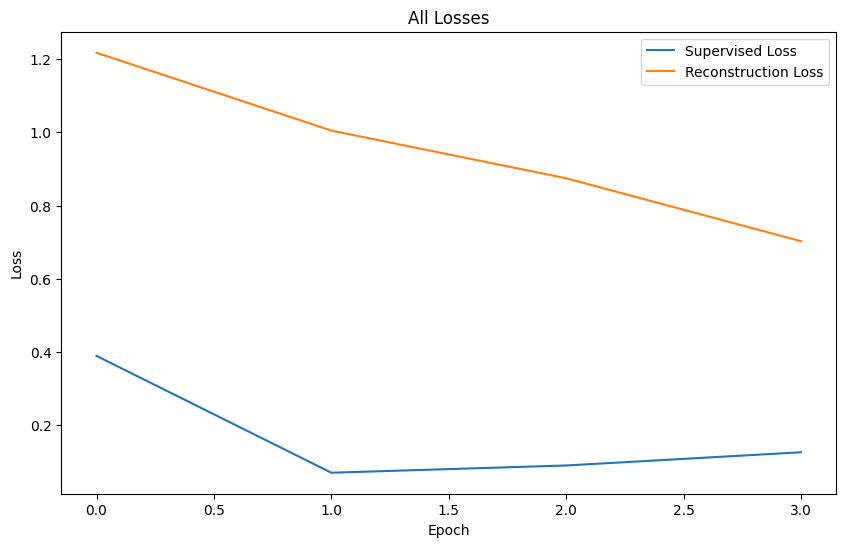

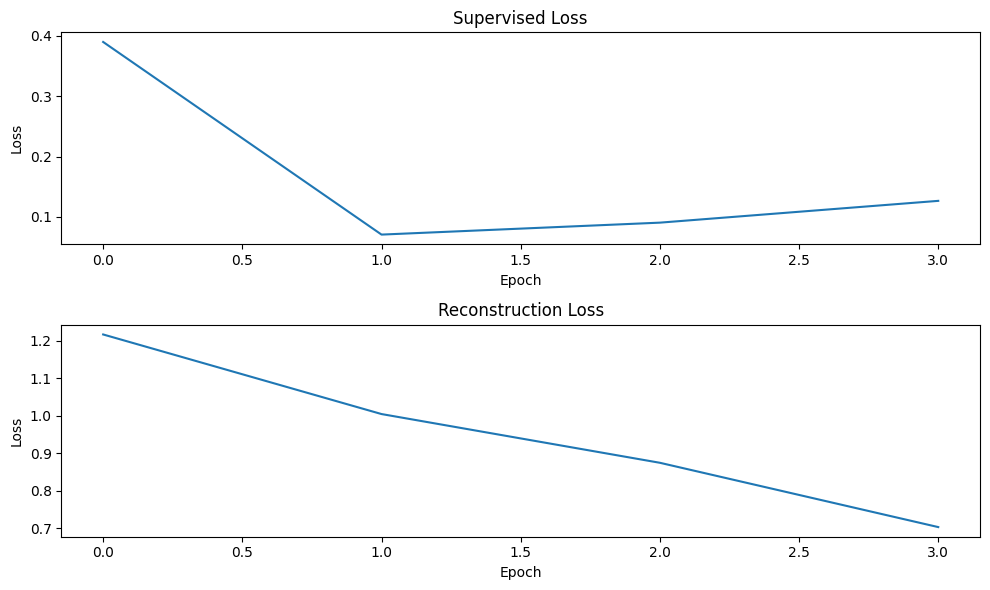

In [18]:
v.plot_losses(autoencoder_losses)

Then plot a comparison of a real data sequence to its corresponding recovered sequence for one of the features.

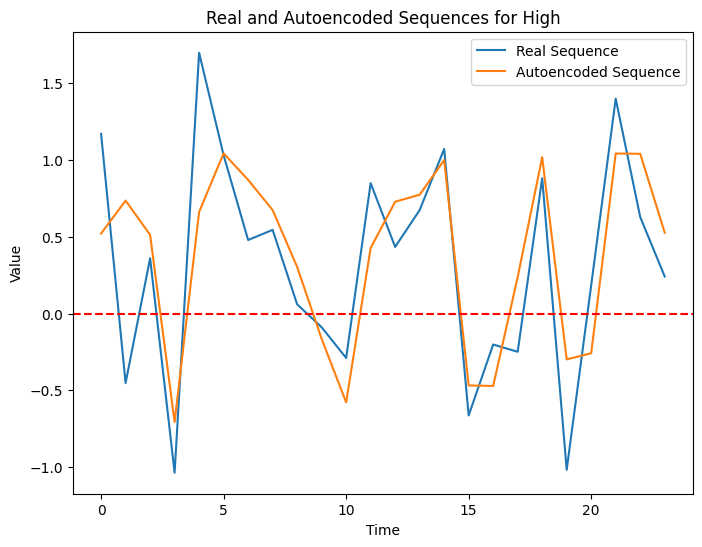

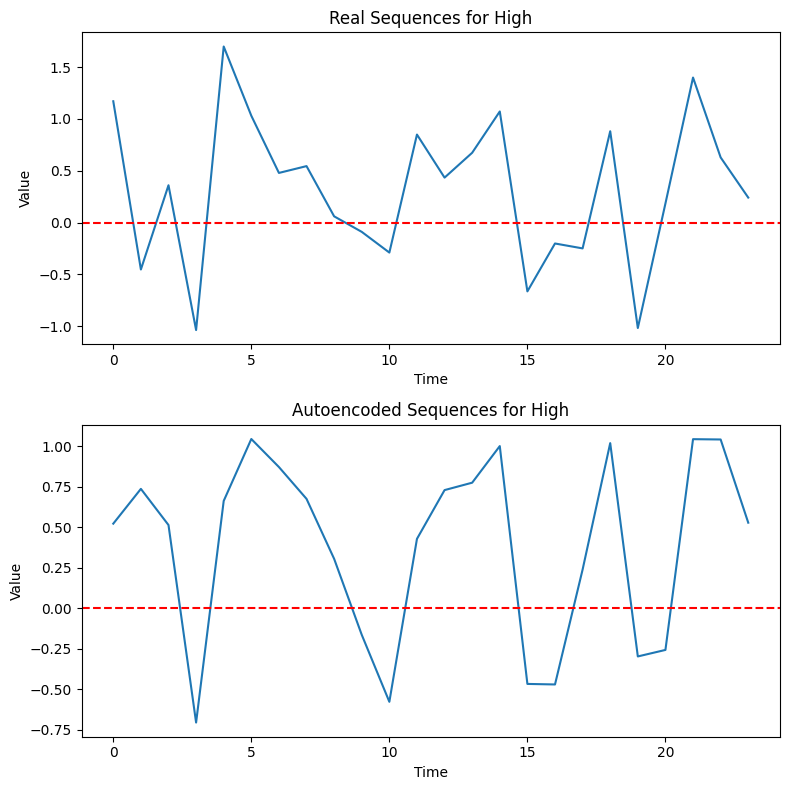

In [20]:
v.plot_autoencoded_sequence(model, sequences, 1, feature_labels)

Then save the model to the current point

### Dynamic Training

The dynamic training consists of updates to five different loss functions:
* **Unsupervised Discriminator Loss:** The Discriminator learns to distinguish between the Generator's synthetic sequences and the Embedder's real sequences by minimizing its classification error of the two. In the dynamic training its important that the Discriminator doesn't become too good too quickly, otherwise it will cease to provide the Generator any meaningful feedback due to Vanishing Gradients, and therefore you can specify the intervals by which the Discriminator should be updated (ex every other step is k=2).
* **Unsuperised Generator Loss:** The Generator learns to mimic the overall sequences by maximizing the Discriminators classification error of its generated sequences, ie it wants the Disciminator to label them as real.
* **Supervised Generator Loss:** The Generator learns the stepwise dynamics of the real data to the Generator updating to create sequences that the Supervisor can easily predict the next step of. This is done by having the Generator minimize the distance between the Supervisors current hidden state output and the Generators next hidden state output (similar to the supervised training above). As the Supervisor has learned how the real data would make a step based on its previous output, the Generator is expected to produce sequences that follow the same pattern that the Supervisor has learned is present in the real sequences. To guide the Generator in learning the stepwise dynamics, the Supervisor is also adjusted to minimize this distance, which makes it easier for the Generator to conform to the Supervisors learned dynamics,
* **Supervised Embedder Loss:** The updates done with the Supervised Generator Loss may cause the Supervisor to unlearn some of the real stepwise dynamics. That's why the Supervisor also needs to be reupdated to minimize the supervised loss for the Embedder's output (note that a parameter exists to balance the two supervised losses described here). This way the Supervisor will relearn the real dynamics, and the Generator will continue to get meaningful feedback from the Supervisor.
* **Reconstruction Loss:** Since the Supervisor is now being updated to adjust to the Generators stepwise dyanmics, the Embedder also needs to be updated to adhere to these new dynamics. This is achieved by having the Embedder minimize the Supervised Embedder Loss. And in turn since the Embedder is being updated, the Recovery network also needs to be updated to conform to this new representation. Which is again done by minimizing the same reconstruction loss from the autoencoder tarining.

Again these losses will be displayed for each Step in each Epoch of the training, and will be summarized in a dictionary at the end of the training.

In [21]:
dynamic_losses = model.fit_dynamic_game(sequences, 5, 2)

Starting Dynamic Training
Epoch 0, step 0: Reconstruction loss = 0.6249649524688721, Supervised E loss = 0.1202743798494339, Supervised G loss = 1.7861469984054565, Unsupervised G loss = 0.6506723761558533, Unsupervised D loss = None
Epoch 0, step 1: Reconstruction loss = 0.6380077600479126, Supervised E loss = 0.12537333369255066, Supervised G loss = 1.6195155382156372, Unsupervised G loss = 0.6822360754013062, Unsupervised D loss = 0.8155257701873779
Epoch 0, step 2: Reconstruction loss = 0.6151673197746277, Supervised E loss = 0.11713479459285736, Supervised G loss = 1.5861661434173584, Unsupervised G loss = 0.6670796871185303, Unsupervised D loss = None
Epoch 0, step 3: Reconstruction loss = 0.7393738627433777, Supervised E loss = 0.1257912516593933, Supervised G loss = 1.4797927141189575, Unsupervised G loss = 0.6397523880004883, Unsupervised D loss = 0.7780213356018066
Epoch 0, step 4: Reconstruction loss = 0.6545804738998413, Supervised E loss = 0.11779683083295822, Supervised G

Next plot the losses from the dyanmic training. The Supervised Embedder and Reconstruction losses should be decreasing relatively slowly, as these networks have already been trained. Its also important that the Unsupervised losses converge, as this indicates that neither of the two networks is outperforming the other by too much.

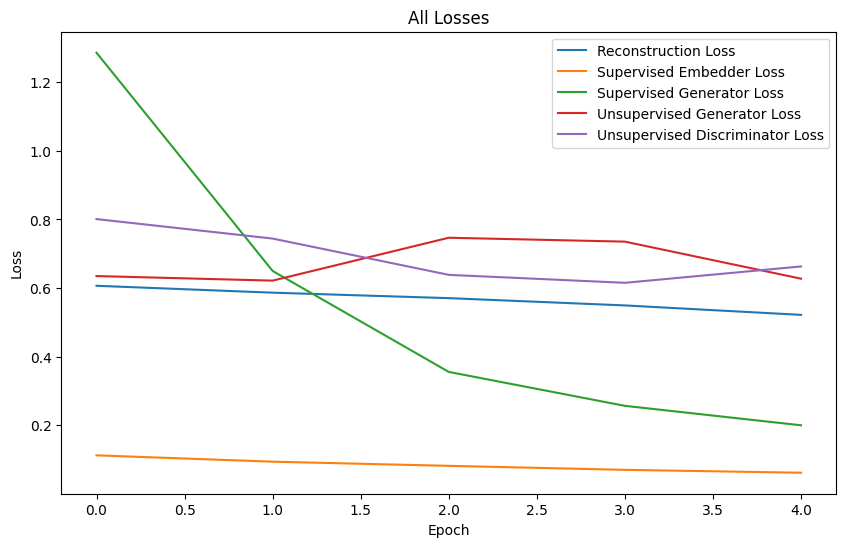

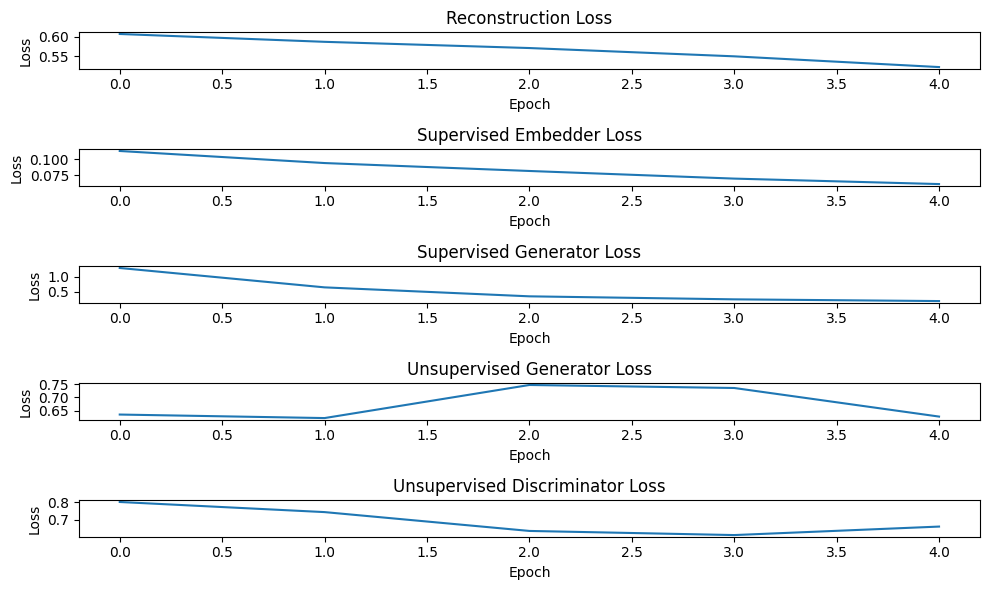

In [22]:
v.plot_losses(dynamic_losses)

Again plot a comparison of a real data sequence to its corresponding recovered sequence for one of the features.

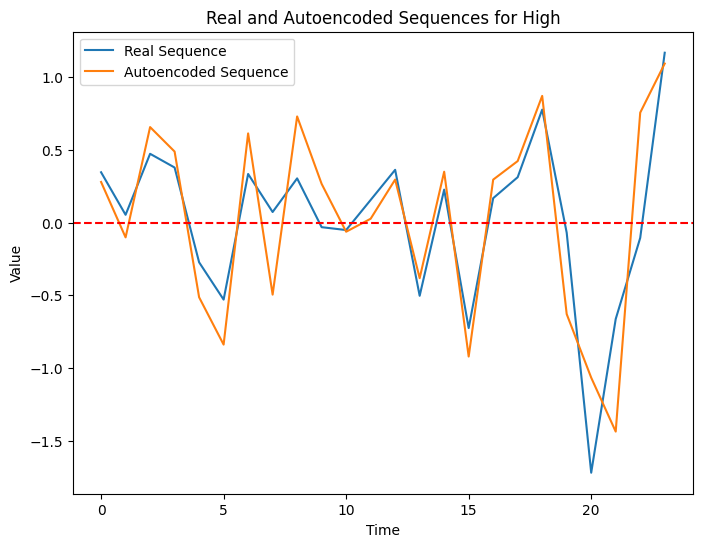

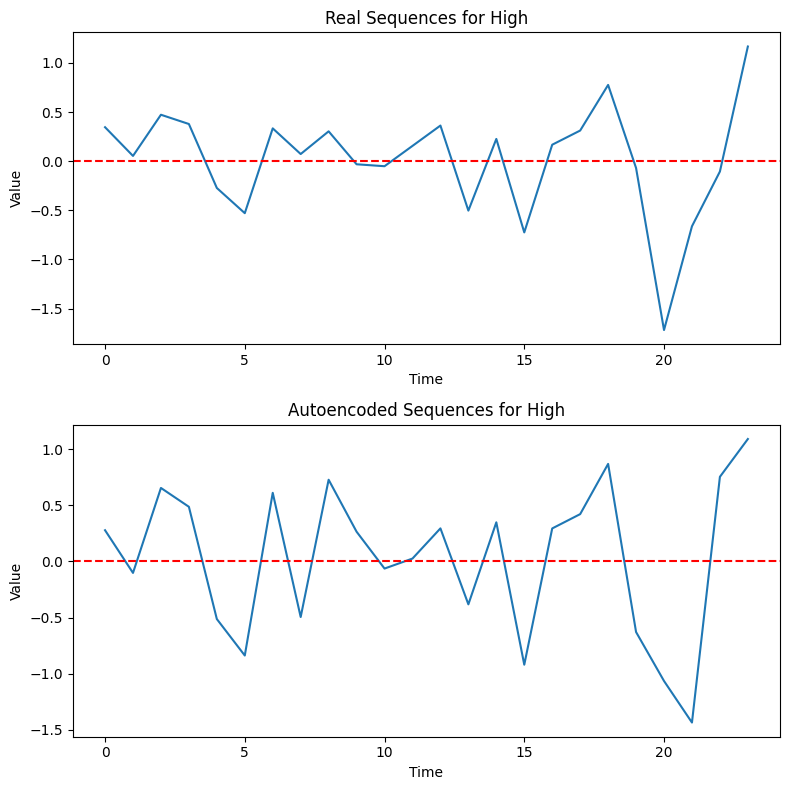

In [23]:
v.plot_autoencoded_sequence(model, sequences, 1, feature_labels)

Then plot a comparison of some of the real autoencoded data and a generated sequence.

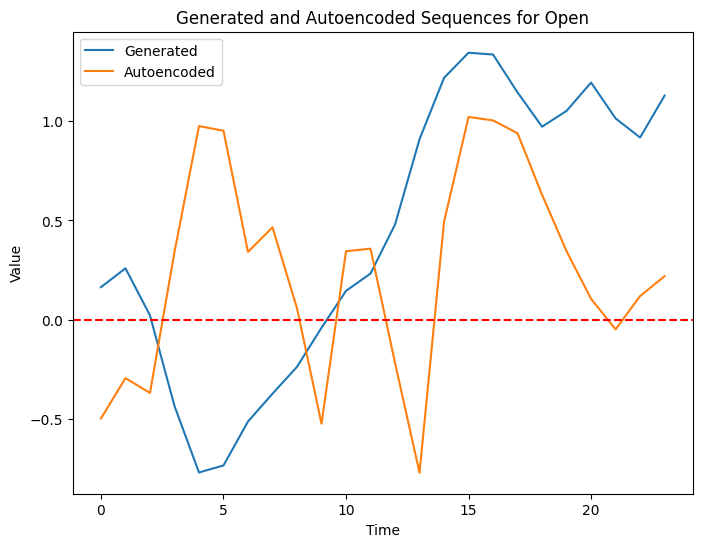

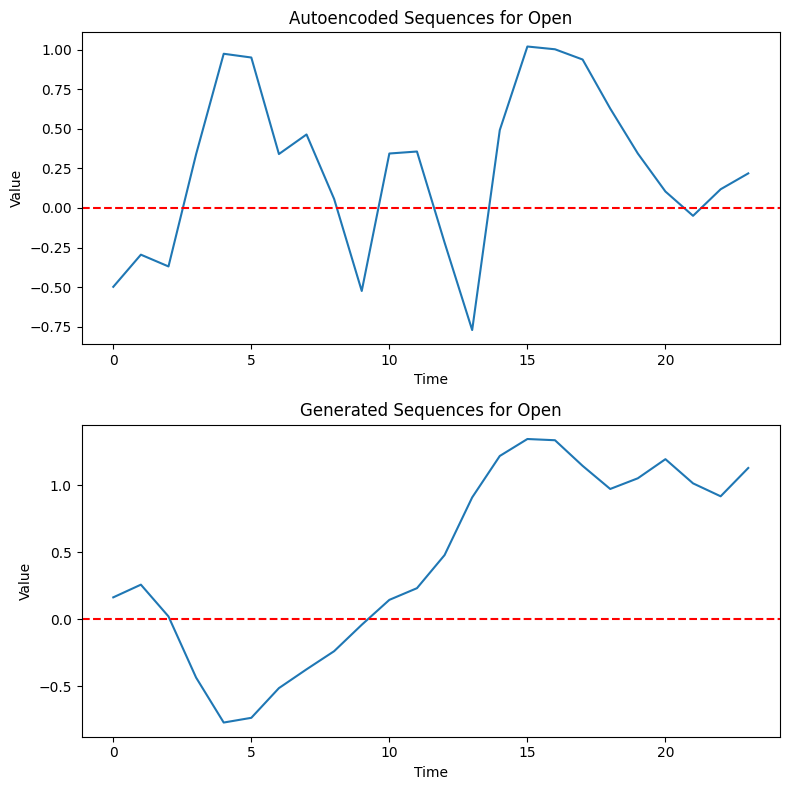

In [32]:
v.plot_generated_sequence(model, sequences, 0, feature_labels)

Finally save the model for use later on.

In [33]:
model.save_models("saved_models", "model_1")

## Syelized Facts of Financial Time Series

This section will check if the synthetic data adheres to the same styelized statistical properties that the real financial time series adheres to.

While financial data can exhibit a large variety of statistical properties across different asset types and markets there are a hanful of statistical properties that are commonly observed across all of them.

First lets define some of the notation to be used in the following section. An assest price at time t will be denoted as X(t), and a duration of time will be defined as Δt (the data used here has Δt=1 day). The percent change in an assets price will then be defined as *r*(t, Δ t) = ln(X(t+Δt))-ln(X(t)), which is what the the timegan model above is build to generate.

The styelized facts tested for here are:

1. **Linear Autocorrelation**: This is the correlation between percent changes over different time periods, or *corr*(*r*(t, Δ t), *r*(t+τ, Δ t)). We expect this value to be 0 for all τ, which indicates that future stock prices can not be linearly predicted based on past prices, in accoredence with the Random Walk Theory of stock returns and Efficient Markets.
2. **Volatility Cluster**: This is the correlation between the volatility of *r* over different time periods, or *corr*(|*r*(t, Δ t)|^β, |*r*(t+τ, Δ t)|^β), where β=1 is used here as this typically exhibits the strongest correlation. We expect this to start out positive and slowly decay as τ increases, which indicates that large price fluctuations are likely followed by large prie fluctuations. While this contradictes the idea that the increments of these sequences are independent, it does not violate the RW Theory as it still impossible to tell in what direction these random shocks will move. All it indicates is that the shocks are not homogenous nor independent.
3. **Leverage Effect:** This is the correlation between the current return and future colatility, or *corr*(*r*(t, Δ t), |*r*(t+τ, Δ t)|^2). We expect this to start out negative and decay to zero, which indicates that negative returns lead to increased volatility. This, combined with the Volatility Clustering, motivates the use of GARCH models and other volatility models. But it's again crucial to note that none of this implies that the retuns themselves can be predicted based on past inofrmation.
4. **Heavy-Tailed Distributions**: